In [17]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
# General imports
import os
from pathlib import Path 
import traceback
import numpy as np
from numpy import linalg as LA
from matplotlib import pyplot as plt

# HyperbolicTSNE imports
from hyperbolicTSNE import Datasets
from hyperbolicTSNE import Datasets, SequentialOptimizer, initialization, HyperbolicTSNE
from hyperbolicTSNE.cost_functions_ import HyperbolicKL, GaussianKL
from hyperbolicTSNE.util import find_last_embedding, opt_config, initialize_logger, write_data, store_visuals
from hyperbolicTSNE.data_loaders import load_mnist
from hyperbolicTSNE.hd_mat_ import hd_matrix
from hyperbolicTSNE.visualization import animate, plot_poincare

# Date generation function
from data_gen import generate_linear_hierarchical_data, generate_uniform_clusters, generate_tree_data

# Dataset generation code
Generate a specific set of samples we want to use.
Right now we want 10 samples of data with labels 2 and 4.

In [19]:
# MNIST DATA 

# n_samples = 20             # How much to sample from each class
# dataX, dataLabels = load_mnist(data_home=data_home)
# print(dataX.shape, dataLabels.shape)

# indices_2 = np.where(dataLabels == 2)
# indices_4 = np.where(dataLabels == 4)

# samples_idx_2 = np.random.choice(indices_2[0], size=n_samples, replace=False)
# samples_idx_4 = np.random.choice(indices_4[0], size=n_samples, replace=False)

# print(samples_idx_2)
# print(samples_idx_4)

# print(dataLabels[samples_idx_2])
# print(dataLabels[samples_idx_4])

# labels_2 = dataLabels[samples_idx_2]
# labels_4 = dataLabels[samples_idx_4]
# sample_labels = np.concatenate((labels_2, labels_4), axis=0)

# samples_2 = dataX[samples_idx_2]        # samples of number 2
# samples_4 = dataX[samples_idx_4]        # samples of number 4
# sample_data = np.concatenate((samples_2, samples_4), axis=0)    # Contains both 2 and 4 

# print(sample_data.shape)    

# Preperation for running embedding
Get the distance matrix and affinity matrix of our samples
Generate custom dataset (see below)

In [29]:
n_samples = 5
n_clusters = 2
n_dim = 2
start = -100
end = 100

# Generate data
# dataX, dataLabels = generate_linear_hierarchical_data(n_samples, n_clusters, n_dim, start, end)
# dataX = dataX.reshape((dataX.shape[0] * dataX.shape[1], dataX.shape[2]))
dist = 4
angle = np.pi / 4
dataX, dataLabels = generate_tree_data(dist, angle)

# Visualize generated data

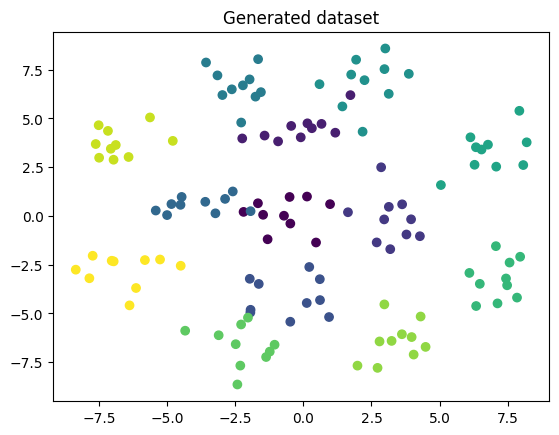

In [30]:
plt.scatter(dataX[:, 0], dataX[:, 1], c=dataLabels)

plt.title("Generated dataset")
plt.show()

In [31]:
hd_params = {"perplexity": n_samples}
D, V = hd_matrix(X=dataX, D=None, V=None,
                    knn_method="sklearn", metric="euclidean", n_neighbors=n_samples, knn_params=None,
                    hd_method="vdm2008", hd_params=hd_params, verbose=1)

Computing the kNN D matrix with k=16 nearest neighbors...
Using sklearn NearestNeighbor, an exact method, for the knn computation
Indexed 130 samples in 0.000s...
Computed neighbors for 130 samples in {duration:.3f}s...
`hd_method` set to `vdm2008`, running with perplexity 5. Returns (D, V)
[t-SNE] Computed conditional probabilities for sample 130 / 130
[t-SNE] Mean sigma: 0.916022


# Initialization

In [32]:
data_home = "datasets"
log_path = "temp/poincare/"  # path for saving embedding snapshots
grad_path = "temp/grad/"     # NOTE: We will manually calculate the gradients

seed = 42

dataset = Datasets.MNIST
num_points = [-1]
perplexities = [50]
correct_gradient = True                          # NOTE: Recompile with correct flag (GRAD_FIX flag)
exact = True                                     # Exact computation or BH estimation of gradient
pca_components = 0                               # Whether to use pca initialization of high dim. data or not
grad_scale_fix = True                            # Whether we multiply the gradient by the inverse metric tensor of hyperbolic space or not
                                                 # Note that the correct hyperoblic gradient has an inverse metric tensor factor

# Simple experiment with no exaggeration
exaggeration_factor = 12
ex_iterations = 0
main_iterations = 1000

# Run embedding
Code below runs the embedding procedure for our specified dataset

We compute embeddings for the correct gradient version, and then manually compute the wrong gradient using the embeddings produced by the correct gradient

In [33]:
# Compute initial embedding in Poincare disk (PCA embedding)
cf = HyperbolicKL
X_embedded = initialization(
    n_samples=dataX.shape[0], 
    n_components=2,
    X=dataX,
    random_state=seed,
    method="random"
) 

# Initialize config and parameters
learning_rate = (dataX.shape[0] * 1) / (exaggeration_factor * 1000)

opt_conf = opt_config(cf, learning_rate, exaggeration_factor, ex_iterations, main_iterations, exact=exact, grad_scale_fix=True, grad_fix=correct_gradient)
opt_params = SequentialOptimizer.sequence_poincare(**opt_conf) 

log_path_cf = log_path + f"cf_{cf.class_str()}/correct_grad_{correct_gradient}/"
grad_path_grad = grad_path + f"cf_{cf.class_str()}/correct_grad_{correct_gradient}/"

opt_params, opt_conf = initialize_logger(opt_params, opt_conf, log_path_cf, grad_path_grad)
opt_params["cf_params"].update({"grad_fix" : correct_gradient})     # So the cost function knows which gradient to use

Please note that `empty_sequence` uses the KL divergence with Barnes-Hut approximation (angle=0.5) by default.
config: {'cf': <class 'hyperbolicTSNE.cost_functions_.HyperbolicKL'>, 'learning_rate_ex': 0.010833333333333334, 'learning_rate_main': 0.010833333333333334, 'exaggeration': 12, 'exaggeration_its': 0, 'gradientDescent_its': 1000, 'vanilla': False, 'momentum_ex': 0.5, 'momentum': 0.8, 'exact': True, 'area_split': False, 'n_iter_check': 10, 'size_tol': 0.999, 'grad_scale_fix': True, 'grad_fix': True}


In [34]:
# Set up H-TSNE object 
htsne = HyperbolicTSNE(
    init=X_embedded, 
    n_components=2, 
    metric="precomputed",
    verbose=1, 
    opt_method=SequentialOptimizer,         # the optimizater we use
    opt_params=opt_params              # the parameters for the optimizers
    )

# Compute embedding:
try:
    hyperbolicEmbedding = htsne.fit_transform((D, V))
    
except ValueError:
    hyperbolicEmbedding = find_last_embedding(log_path)
    traceback.print_exc()

[HyperbolicTSNE] Received iterable as input. It should have len=2 and contain (D=None, V=None)
[hd_mat] Warning: There is nothing to do with given parameters. Returning given D and V
Running Gradient Descent, Verbosity: 1
[gradient_descent] Warning: because of logging, the cf will be computed at every iteration


Gradient Descent: 0it [00:00, ?it/s]


Running Gradient Descent, Verbosity: 1
[gradient_descent] Warning: because of logging, the cf will be computed at every iteration


Gradient Descent error: 0.68358 grad_norm: 1.31902e-03:  70%|███████   | 700/1000 [00:01<00:00, 420.18it/s]

4


Animation being saved to: results/gradient_vis_images/gradienttesting_cf_HyperbolicKL_correctgrad_True.gif


Animating:   0%|          | 0/141 [00:00<?, ?it/s]/Users/haoranxia/Thesis-Delft/hyperbolic-tsne/hyperbolicTSNE/visualization.py:322: UserWarning: You passed in an explicit save_count=50 which is being ignored in favor of frames=141.
  anim = FuncAnimation(fig, update, frames=len(scatter_data), interval=50, blit=True, save_count=50)
MovieWriter ffmpeg unavailable; using Pillow instead.
Animating: : 144it [00:03, 39.92it/s]                       


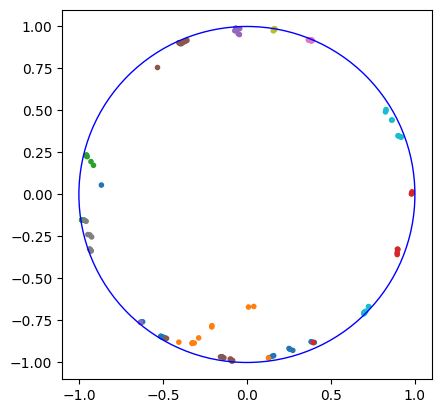

In [35]:
 # Store visuals
save_folder = "results/gradient_vis_images"
file_name = f"{save_folder}/gradienttesting_cf_{cf.class_str()}_correctgrad_{correct_gradient}"

# Create folder if it doesn't exist
path = Path(save_folder)
path.mkdir(parents=True, exist_ok=True)

fig = plot_poincare(hyperbolicEmbedding, dataLabels)
fig.savefig(f"{file_name}.png")

# Save animation
animate(opt_params["logging_dict"], dataLabels, f"{file_name}.gif", fast=True, plot_ee=True)

# Gradient computation


First we compute the gradients for the GaussianKL results

In [12]:
from gradient_experiments import GradientComparisons
from pathlib import Path

embedding_folder_path = f"temp/poincare/cf_{cf.class_str()}/correct_grad_True"              # Where our embeddings are 
output_folder_path = f"results/gradient_comparisons/cf_{cf.class_str()}"                    # Where to store our results
V = V                                                                                       # High dim. affinity matrix, precomputed

# For each type of gradient, calculate the gradients and store the results
for correct_gradient in [True, False]:
    # Initialize config and parameters
    learning_rate = (dataX.shape[0] * 1) / (exaggeration_factor * 1000)

    opt_conf = opt_config(cf, learning_rate, exaggeration_factor, ex_iterations, main_iterations, exact=exact, grad_scale_fix=True, grad_fix=correct_gradient)
    opt_params = SequentialOptimizer.sequence_poincare(**opt_conf) 
    opt_params["cf_params"].update({"grad_fix" : correct_gradient})         # So the cost function knows which gradient to use
    params = opt_params["cf_config_params"] | opt_params["cf_params"]       # Params to initialize cf

    key = f"linear_hierarchical_data_nclusters:{n_clusters}_ndata:{n_samples}"
    cf = HyperbolicKL(n_components=2, other_params=params)                  
    
    # Run experiment
    Experiment_Gradients = GradientComparisons(embedding_folder_path, cf, key)  
    Experiment_Gradients.compute_gradients(V, correct_gradient, output_folder_path)

Please note that `empty_sequence` uses the KL divergence with Barnes-Hut approximation (angle=0.5) by default.
Please note that `empty_sequence` uses the KL divergence with Barnes-Hut approximation (angle=0.5) by default.


# Analysis of HyperbolicKL 

In [13]:
def plot_gradient(directory, node, type):
    """
    directory:      Directory with the gradients we want to plot
    node:           Int representing node we want to plot gradients of
    type:           String with the type of gradient (correct/wrong)
    """
    # Loop over all gradient files
    files = sorted(directory.iterdir(), key=lambda file: int(file.name.split(".")[0]))
    data_size = len(files)
    grads = np.zeros((data_size, 2))

    for idx, grad_file in enumerate(files):
        data = np.loadtxt(str(grad_file), delimiter=',')
        grads[idx] = data[node]

    # Establish x-coordinates
    xs = np.array([x for x in range(data_size)])   

    # Compute norms
    grads = np.linalg.norm(grads, axis=1)

    plt.scatter(xs, grads, s=10)
    plt.title(f"{type} Gradient norm of emb: {node}")
    plt.ylabel(f"Norm")
    plt.xlabel("Iteration")
    plt.show()

    # So we can use them for later
    return grads

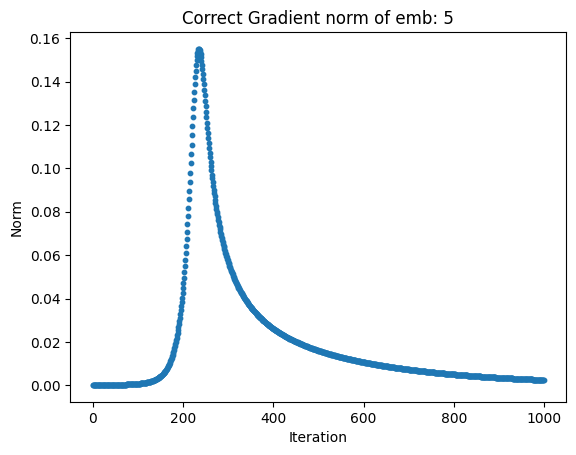

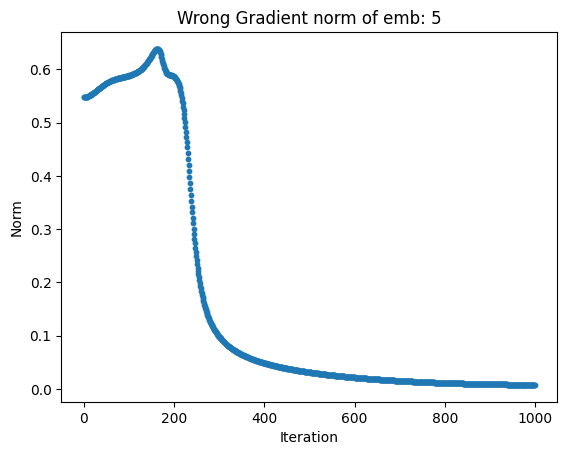

In [14]:
# Plot correct gradient data of node {node}
node = 5
correct_grad_directory = Path("results/gradient_comparisons/cf_HyperbolicKL/correct_grad_True")
wrong_grad_directory = Path("results/gradient_comparisons/cf_HyperbolicKL/correct_grad_False")

grads_c = plot_gradient(correct_grad_directory, node, "Correct")
grads_w = plot_gradient(wrong_grad_directory, node, "Wrong")

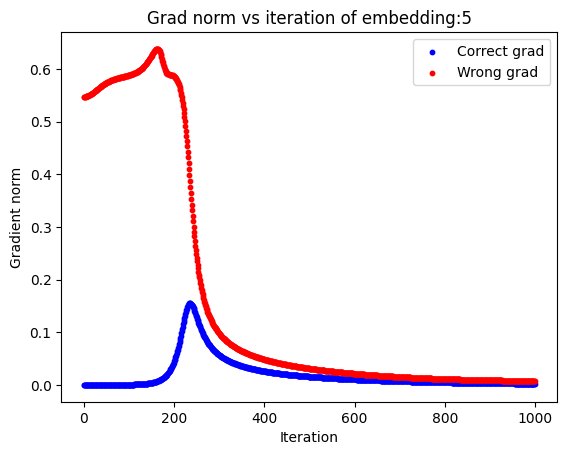

In [15]:
xs = np.array([x for x in range(grads_c.shape[0])])   
plt.scatter(xs, grads_c, s=10, c="blue", label="Correct grad")
plt.scatter(xs, grads_w, s=10, c="red", label="Wrong grad")

plt.title(f"Grad norm vs iteration of embedding:{node}")
plt.ylabel("Gradient norm")
plt.xlabel("Iteration")

plt.legend()
plt.show()

### Gradient Visualization

Visualize gradients for a specific iteration of the embedding process.

In [22]:
gradients_directory = Path("results/gradient_comparisons/cf_HyperbolicKL/")

# The iteration we want to analyze
emb_it = 500                              

# Load gradients corresponding to "emb_it"
data = dict()
for correct_grad in [True, False]:
    gradient_folder = Path(f"results/gradient_comparisons/cf_HyperbolicKL//correct_grad_{correct_grad}")
    # Load gradient data from the iteration we want
    gradient_file_path = Path(f"{gradient_folder}/{emb_it}.csv")
    gradient_data = np.loadtxt(str(gradient_file_path), delimiter=',')
    key = "Correct_Grad" if correct_grad else "Wrong_Grad"
    data[key] = gradient_data

# Load embedding corresponding to "emb_it"
embeddings_directory = Path("temp/poincare/cf_HyperbolicKL/correct_grad_True/solver_gradient_descent_sequential_opt_1")
emb_file_path = Path(f"{embeddings_directory}/{emb_it}.csv")
emb_data = np.loadtxt(str(emb_file_path), delimiter=',')
data["Emb"] = emb_data

In [23]:
# Testing data shape and such. Sanity checks

# for key in data:
#     print(key)
#     print(data[key])
#     print()

print(data["Emb"].shape)
print(data["Emb"][:, 0])
print(data["Emb"][0])
# Note that the indices of dataLabels correspond to indices of data["Emb"]
print(dataLabels)

(10, 2)
[ 0.45594718  0.4507653   0.45341471  0.45112036  0.45602179 -0.45127697
 -0.45901505 -0.44852442 -0.45305677 -0.4554434 ]
[0.45594718 0.50828685]
[0 0 0 0 0 1 1 1 1 1]


Plot the correct/wrong gradients corresponding to our chosen embedding.

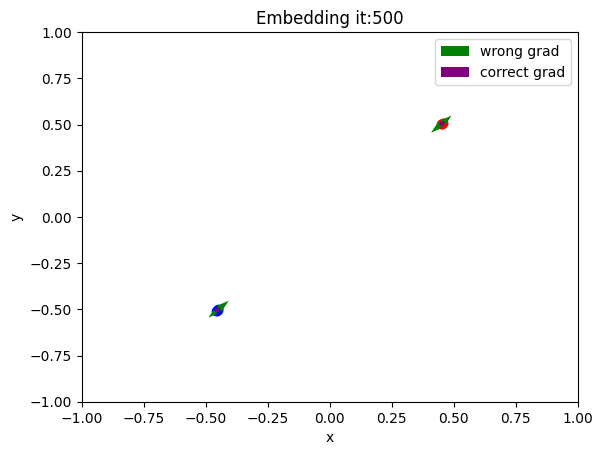

In [24]:
from matplotlib import pyplot as plt

scaling_factor = 1
grad_scaling_factor = 1
wrong_grad_scaling_factor = 1

# Plot embedding points
# Create a figure and axis
fig, ax = plt.subplots()

# Plot the embeddings/data
scaled_data = data["Emb"] * scaling_factor

# In our current situation we have 2 clusters with n_samples elements each
ax.scatter(scaled_data[:n_samples, 0], scaled_data[:n_samples, 1], color='red')
ax.scatter(scaled_data[n_samples:, 0], scaled_data[n_samples:, 1], color='blue')

# Plot the gradients 
scaled_wrong_grad = data["Wrong_Grad"] * wrong_grad_scaling_factor
ax.quiver(scaled_data[:, 0], scaled_data[:, 1], scaled_wrong_grad[:, 0], scaled_wrong_grad[:, 1],
          angles='xy', scale_units='xy', scale=1, color='green', label="wrong grad")

# Correct gradient seems to be ~3000 times smaller than wrong gradient (at the start)
scaled_correct_grad = data["Correct_Grad"] * grad_scaling_factor
ax.quiver(scaled_data[:, 0], scaled_data[:, 1], scaled_correct_grad[:, 0], scaled_correct_grad[:, 1],
          angles='xy', scale_units='xy', scale=1, color='purple', label="correct grad")

# Set axis limits
ax.set_xlim([-1, 1])
ax.set_ylim([-1, 1])

# Add labels and title
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title(f'Embedding it:{emb_it}')

ax.legend()

# Show the plot
plt.show()

### Numerical analysis of gradients

Investigate the probability distributions of high/low dim. respectively between the 2 gradients
Investigate ratio of gradients between correct/wrong gradient

In [25]:
# Hyperbolic distance between y1, y2
def hyp_dist(y1, y2):
    diff = y1 - y2
    num = diff.dot(diff)                         # numerator
    denum = (1 - y1.dot(y1)) * (1 - y2.dot(y2))  # denumerator
    dist = np.arccosh(1 + 2 * (num / denum))

    return dist


# Compute the probability distribution associated with our embedding.
# Low dimensional affinities, computed from embeddings 
def compute_affinities(embedding_data):
    Q = np.zeros((embedding_data.shape[0], embedding_data.shape[0]))
    for i in range(Q.shape[0]):
        for j in range(i + 1, Q.shape[1]):
            dist = hyp_dist(embedding_data[i], embedding_data[j])       # hyp. distance
            dist = 1. / (1 + dist**2)                                   # t-distrib. "distance"
            Q[i][j] = dist
            Q[j][i] = dist

    # Normalize distances to probabilities
    # return Q / Q.sum()
    return Q / Q.sum()

In [26]:
# Recomputing probability matrices
P = V.toarray() 
Q = compute_affinities(data["Emb"])

print(P)
print()
print(Q)

print(P - Q)

[[0.         0.02347441 0.02360789 0.02351587 0.02380003 0.00107123
  0.00084631 0.00116943 0.001018   0.00094085]
 [0.02347441 0.         0.02371988 0.02379308 0.02350809 0.00126072
  0.00099186 0.00135556 0.00119651 0.00111054]
 [0.02360789 0.02371988 0.         0.02371667 0.02363857 0.00116544
  0.00091259 0.0012567  0.00110532 0.00102385]
 [0.02351587 0.02379308 0.02371667 0.         0.02354164 0.00124765
  0.00098319 0.00134371 0.00118455 0.00109923]
 [0.02380003 0.02350809 0.02363857 0.02354164 0.         0.00106907
  0.00084052 0.00116403 0.00101498 0.00093789]
 [0.00107123 0.00126072 0.00116544 0.00124765 0.00106907 0.
  0.02326345 0.02383078 0.023859   0.02375803]
 [0.00084631 0.00099186 0.00091259 0.00098319 0.00084052 0.02326345
  0.         0.02328548 0.02351126 0.02371314]
 [0.00116943 0.00135556 0.0012567  0.00134371 0.00116403 0.02383078
  0.02328548 0.         0.02376897 0.02358193]
 [0.001018   0.00119651 0.00110532 0.00118455 0.00101498 0.023859
  0.02351126 0.0237689

In [37]:
""" 
Visually, on the poincare disk, points at (-0.99, 0) and (0.99, 0) are near the boundaries of the disk. 
But their hyperbolic distance is quite small. Meaning that embedding wise, they might be close to eachother.

If we want to make points spread out less, would that make conceptual sense?
"""

y_1 = np.array([-0.99, 0])
y_2 = np.array([0.99, 0])
dist = hyp_dist(y_1, y_2)
print(dist)

y_1 = np.array([-9.90e-10, 0])
y_2 = np.array([0.99999999999, 0])
dist = hyp_dist(y_1, y_2)
print(dist)

10.586609649448981
26.021583122724078


# Analysis of behaviour at beginning (early iterations)

1. hyp. distances are small $d^{H}_{ij}$ approaches 0 (since $cosh^{-1} goes to 0), since its argument goes to 1.

2. This means t-distrib. probability goes to 1, $(1 + (d^{H}_{ij})^2)^{-1}$ goes to 1.
So once normalized, all probabilities $q^{H}_{ij}$ are almost the same for all $ij$, so we basically have an uniform distribution for $q^{H}_{ij}$

3. Why are the wrong gradients so much bigger?

Correct Gradient expression:
$$ 4  \sum_{j} (p_{ij} - q^{H}_{ij}) (1 + (d^{H}_{ij})^2)^{-1}  d^{H}_{ij} \frac{d^{H}_{ij}}{y_i}$$

\
Wrong Gradient expresion:
$$ 4  \sum_{j} (p_{ij} - q^{H}_{ij}) (1 + (d^{H}_{ij})^2)^{-1} \frac{d^{H}_{ij}}{y_i}$$

\
Because in early iterations, $ d^{H}_{ij} $ is approximately 0, the correct gradient is very small, until points haved moved sufficiently for this term to increase in value.

Can this possibly replace early exaggeration? Maybe.. 
At the beginning, points are updated in very small amounts. But this applies to both attractive and repulsive forces.

At some points, points are "distant" enough, for $ d^{H}_{ij} $ to not matter much anymore. 

$ d^{H}_{ij} $ goes up a lot (to possibly infinity) for larger distances. This means that forces between distant points get heavily amplified. Is this an issue though? Since very distant forces should be more or less 0?

4. Is the use of the t-distribution justified in hyperbolic space?
Is it making repellant points feel a repellant force for way too far distances?
What do p, q look like for points far away? Is the heavy-tailedness a problem in hyperbolic space?

Despite large distances, $ q^{H}_{ij} $ is never able to reach the "correct" probabilities due to the use of the t-distribution? Since the heavy tails requires too big of distances for things to converge properly. Hence points keep getting pushed out? 

We can try using a regular gaussian distribution for $ q^{H}_{ij} $. Rederive the gradient, and experiment with that.
But do we then need to take the symmetric version into account?